In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision    
import os
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from imblearn.over_sampling import SMOTE
import random
from sklearn.metrics import f1_score
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 20
images_data_path = 'C:/Users/rotem/Dropbox/My PC (LAPTOP-8PKPR4J5)\Downloads\X-ray'
transform = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
data_tensor = datasets.ImageFolder(images_data_path,       
                    transform=transform)
targets = data_tensor.targets
classes, class_counts = np.unique(targets, return_counts=True)
print(class_counts)
print(len(data_tensor))
print(data_tensor[0][0].shape)
images = []
for data in data_tensor:
    image, labels = data
    images.append(image.numpy().flatten())
images = np.array(images)

cuda
[10192  3616  1345]
15153
torch.Size([3, 299, 299])


In [2]:
data, label = SMOTE().fit_resample(images, np.array(targets))
data = data.reshape((data.shape[0],3,299,299))
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data),torch.from_numpy(label))
print(len(dataset))
lables = []
for data in dataset:
    image, labels = data
    lables.append(labels.item())
classes, class_counts = np.unique(lables, return_counts=True)
print(class_counts)

30576
[10192 10192 10192]


In [3]:
valid_size = .1
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]
val_idx = train_idx[:len(test_idx)]
train_idx = train_idx[len(test_idx):]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)
trainloader = torch.utils.data.DataLoader(dataset,
                   sampler=train_sampler, batch_size=32, drop_last=True)
testloader = torch.utils.data.DataLoader(dataset,
                   sampler=test_sampler, batch_size=32, drop_last=True) 
valdloader = torch.utils.data.DataLoader(dataset,
                   sampler=val_sampler, batch_size=32, drop_last=True) 
single_batch = next(iter(trainloader))
single_image = single_batch[0][0]
print(len(trainloader) * 32)
print(len(testloader) * 32)
print(len(valdloader) * 32)
print(single_image.shape)

24448
3040
3040
torch.Size([3, 299, 299])


In [4]:
model = models.inception_v3(pretrained=True)
classifier_input = model.fc.in_features
num_labels = 3
model.fc = nn.Linear(classifier_input, num_labels)
model.to(device)
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
y_test_train =[[],[],[]]
y_score_train =[[],[],[]]
y_test_val =[[],[],[]]
y_score_val =[[],[],[]]
acc_train = []
acc_val = []
e_train_loss = []
e_val_loss = []
f1_score_train = []
f1_score_val = []
for e in range(50):
    # TRAINING
    running_loss = 0.0
    running_corrects = 0
    vald_loss = 0.0
    vald_corects = 0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0
    model.train()
    for inputs, labels in trainloader:
         inputs, labels = inputs.to(device), labels.to(device)
         optimizer.zero_grad()
         outputs, aux = model(inputs)
         _, preds = torch.max(outputs, 1)
         #prediction = outputs.argmax(dim=1, keepdim=True)
         loss = criterion(outputs, labels.long())
         loss.backward()
         optimizer.step()
         total_train += labels.size(0)
         correct_train += (preds == labels.long()).sum().item()
         running_loss += loss.item() * inputs.size(0)
         for i in range(3): 
            y_test_train[i].extend((labels.view_as(preds) == i).cuda())
            y_score_train[i].extend((outputs.cpu().detach()[:, i]).numpy())
         #y_score_train.append(outputs.cpu().detach().numpy())
         #y_test_train.append(labels.cpu().detach().numpy())
    # VALIDATION
    with torch.no_grad():
        model.eval()
        for inputs_val, labels_val in valdloader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = model(inputs_val)           
            _, preds_val = torch.max(outputs_val, 1)
            #prediction_val = outputs.argmax(dim=1, keepdim=True)            
            loss = criterion(outputs_val, labels_val.long())
            total_val += labels_val.size(0)
            correct_val += (preds_val == labels_val.long()).sum().item()
            vald_loss  += loss.item() * inputs.size(0)
            for i in range(3): 
                y_test_val[i].extend((labels_val.view_as(preds_val) == i).cuda())
                y_score_val[i].extend((outputs_val.cpu()[:, i]).numpy())
           # y_score_val.append(outputs_val.cpu().numpy())
           # y_test_val.append(labels_val.cpu().numpy())
  
    print("epoch : {}/{}, Cross Entropy loss train = {:.8f}".format(e + 1, 50,  (running_loss/len(trainloader))))
    #print("epoch : {}/{}, Train Accuracy = {:.8f}".format(e + 1, 11, accuracy = 100 * correct / len(trainset)))
    e_train_loss.append((running_loss/len(trainloader)))
    acc_train.append((100 * correct_train / total_train))
    f1_score_train.append(f1_score(labels.cpu(), preds.cpu(), average='weighted'))
    f1_score_val.append(f1_score(labels_val.cpu(), preds_val.cpu(), average='weighted'))
    e_val_loss.append((vald_loss/len(valdloader)))
    acc_val.append((100 * correct_val / total_val))
    print("epoch : {}/{}, Cross Entropy loss vald = {:.8f}".format(e + 1, 50,  (vald_loss/len(valdloader))))
    #print("epoch : {}/{}, vald Accuracy = {:.8f}".format(e + 1, 11, batch_val_acc))


epoch : 1/50, Cross Entropy loss train = 4.82053388
epoch : 1/50, Cross Entropy loss vald = 0.98437617
epoch : 2/50, Cross Entropy loss train = 1.01810856
epoch : 2/50, Cross Entropy loss vald = 0.41819987
epoch : 3/50, Cross Entropy loss train = 0.50539176
epoch : 3/50, Cross Entropy loss vald = 0.37787295
epoch : 4/50, Cross Entropy loss train = 0.29180282
epoch : 4/50, Cross Entropy loss vald = 0.22345700
epoch : 5/50, Cross Entropy loss train = 0.19988107
epoch : 5/50, Cross Entropy loss vald = 0.38685708
epoch : 6/50, Cross Entropy loss train = 0.10180041
epoch : 6/50, Cross Entropy loss vald = 0.33116341
epoch : 7/50, Cross Entropy loss train = 0.12655610
epoch : 7/50, Cross Entropy loss vald = 0.19332655
epoch : 8/50, Cross Entropy loss train = 0.06804620
epoch : 8/50, Cross Entropy loss vald = 0.45021241
epoch : 9/50, Cross Entropy loss train = 0.05706160
epoch : 9/50, Cross Entropy loss vald = 0.22338926
epoch : 10/50, Cross Entropy loss train = 0.04562675
epoch : 10/50, Cross

C:\Users\rotem\anaconda3\envs\gpu2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


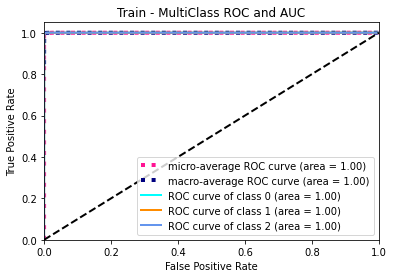

In [6]:
## Train set ROC AUC
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
n_classes = 3
items_array = []
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    for tensor in y_test_train[i]:
        items_array.append(tensor.item())
        
    fpr[i], tpr[i], _ = roc_curve(items_array, y_score_train[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    items_array.clear()

fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test_train).ravel().astype(int), np.array(y_score_train).ravel().astype(int))
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train - MultiClass ROC and AUC')
plt.legend(loc="lower right")
plt.show()


C:\Users\rotem\anaconda3\envs\gpu2\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


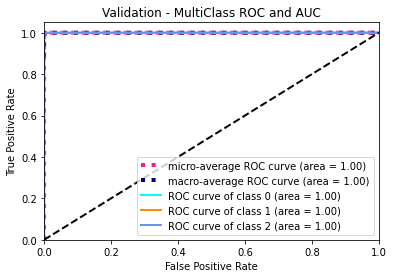

In [7]:
## Validation set ROC AUC

n_classes = 3
items_array = []
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    for tensor in y_test_val[i]:
        items_array.append(tensor.item())
        
    fpr[i], tpr[i], _ = roc_curve(items_array, y_score_val[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    items_array.clear()

fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test_val).ravel().astype(int), np.array(y_score_val).ravel().astype(int))
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation - MultiClass ROC and AUC')
plt.legend(loc="lower right")
plt.show()


In [8]:
y_test_test =[[],[],[]]
y_score_test =[[],[],[]]
acc_test = []
f1_score_test = []
correct = 0
total = 0
with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds_val == labels.long()).sum().item()
            for i in range(3): 
                y_test_test[i].extend((labels.view_as(predicted) == i).cuda())
                y_score_test[i].extend((outputs.cpu()[:, i]).numpy())
            f1_score_test.append(f1_score(labels_val.cpu(), preds_val.cpu(), average='weighted'))
            acc_test.append((100 * correct / total))


C:\Users\rotem\anaconda3\envs\gpu2\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


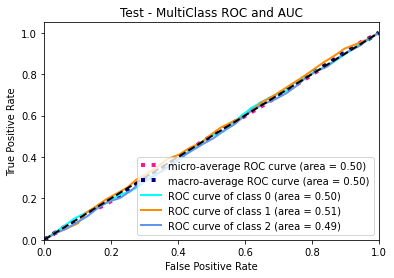

In [9]:
## Validation set ROC AUC

n_classes = 3
items_array = []
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    for tensor in y_test_test[i]:
        items_array.append(tensor.item())
        
    fpr[i], tpr[i], _ = roc_curve(items_array, y_score_test[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    items_array.clear()

fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test_test).ravel().astype(int), np.array(y_score_test).ravel().astype(int))
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test - MultiClass ROC and AUC')
plt.legend(loc="lower right")
plt.show()


In [10]:
## print all our averages of accuracy, F1-score and cross entropy loss for all the Sets 
print("Train Set - Accuracy , F1-Score, Cross Entropy loss: " + str(np.average(acc_train)) + " " + str(np.average(f1_score_train)) + " " + str(np.average(e_train_loss)))
print("Validation Set - Accuracy , F1-Score, Cross Entropy loss: " + str(np.average(acc_val)) + " " + str(np.average(f1_score_val)) + " " + str(np.average(e_val_loss)))
print("Test Set - Accuracy , F1-Score, Cross Entropy loss: " + str(np.average(acc_test)) + " " + str(np.average(f1_score_test)) + " no loss" )

Train Set - Accuracy , F1-Score, Cross Entropy loss: 99.84219568062827 0.9988002232142857 0.15777081484413896
Validation Set - Accuracy , F1-Score, Cross Entropy loss: 99.75460526315788 0.9975167143104645 0.2685288869958175
Test Set - Accuracy , F1-Score, Cross Entropy loss: 36.043880038786774 0.969529625779626 no loss
